In [ ]:
#Upload files from PC (interactive button)
from google.colab import files
import pandas as pd

print("Please choose these 3 files from your computer:")
print("  1. data_rppa.txt")
print("  2. data_mrna_seq_v2_rsem.txt")
print("  3. The_EGFRvIII_Transcriptome_in_glioblastoma_data_public_Zenodo.csv")

uploaded = files.upload()

# Load each file into pandas, keeping it simple for now
rppa = None
rna_raw = None
egfrviii = None

for fn in uploaded.keys():
    if "rppa" in fn.lower():
        rppa = pd.read_csv(fn, sep="\t", index_col=0)
        print("Loaded RPPA:", rppa.shape)
    elif "rna" in fn.lower():
        rna_raw = pd.read_csv(fn, sep="\t", low_memory=False)
        print("Loaded RNA raw:", rna_raw.shape)
    elif "egfr" in fn.lower():
        egfrviii = pd.read_csv(fn)
        print("Loaded EGFRvIII:", egfrviii.shape)

print("\nHeads of the three dataframes:")
print("\nRPPA head (5x5):")
display(rppa.iloc[:5, :5])

print("\nRNA raw head (5 rows):")
display(rna_raw.head())

print("\nEGFRvIII head (5 rows):")
display(egfrviii.head())


Please choose these 3 files from your computer:
  1. data_rppa.txt
  2. data_mrna_seq_v2_rsem.txt
  3. The_EGFRvIII_Transcriptome_in_glioblastoma_data_public_Zenodo.csv


Saving data_rppa.txt to data_rppa (1).txt
Saving data_mrna_seq_v2_rsem.txt to data_mrna_seq_v2_rsem (1).txt
Saving The_EGFRvIII_Transcriptome_in_glioblastoma_data_public_Zenodo.csv to The_EGFRvIII_Transcriptome_in_glioblastoma_data_public_Zenodo (1).csv
Loaded RPPA: (198, 231)
Loaded RNA raw: (20531, 162)
Loaded EGFRvIII: (858, 45)

Heads of the three dataframes:

RPPA head (5x5):


,TCGA-02-0011-01,TCGA-08-0345-01,TCGA-08-0353-01,TCGA-19-1386-01,TCGA-15-1447-01
Composite.Element.REF,,,,,
YWHAE|14-3-3_epsilon,-0.207613,-0.636009,-0.614822,-0.814021,-0.404739
EIF4EBP1|4E-BP1,0.656279,-0.110116,0.795610,-0.122043,0.021175
EIF4EBP1|4E-BP1_pS65,0.543074,0.303296,0.505316,0.549720,0.256577
EIF4EBP1|4E-BP1_pT37T46,1.895562,1.675490,1.811415,2.560177,0.663294
TP53BP1|53BP1,1.089430,2.234210,1.827349,2.022301,1.709573



RNA raw head (5 rows):


,Hugo_Symbol,Entrez_Gene_Id,TCGA-02-0047-01,TCGA-02-0055-01,TCGA-02-2483-01,TCGA-02-2485-01,TCGA-02-2486-01,TCGA-06-0125-01,TCGA-06-0125-02,TCGA-06-0129-01,...,TCGA-41-3915-01,TCGA-41-4097-01,TCGA-41-5651-01,TCGA-76-4925-01,TCGA-76-4926-01,TCGA-76-4927-01,TCGA-76-4928-01,TCGA-76-4929-01,TCGA-76-4931-01,TCGA-76-4932-01
0,NaN,100130426,0.0000,0.0000,0.0000,0.0000,0.0000,0.4604,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,NaN,100133144,3.0732,0.0000,2.9467,15.9952,5.5610,9.9246,3.3758,22.3207,...,8.2279,15.2648,1.2190,12.2160,9.5716,2.4096,10.1709,8.4757,6.1600,0.0000
2,UBE2Q2P2,100134869,6.7611,15.6973,13.9398,14.9571,4.8049,11.6684,3.3862,16.8239,...,10.2174,13.8987,10.3611,17.3596,13.9689,6.4257,6.4812,3.2496,7.9576,9.9502
3,HMGB1P1,10357,54.7036,31.3945,60.3441,91.8238,62.5366,52.1491,41.6125,76.2289,...,35.5731,27.6285,70.0838,108.1350,70.5556,43.0201,42.4584,62.2278,58.8188,60.1990
4,NaN,10431,886.3210,885.7740,1234.8300,470.0000,546.3410,391.9330,419.2460,642.3830,...,512.5160,593.2460,507.6950,531.9330,588.0410,620.8840,533.7420,668.9000,458.3530,499.5020



EGFRvIII head (5 rows):


,Unnamed: 0,X,sample.id,wt.reads.full,vIII.reads.full,n.exon1.spliced.reads.full,EGFRvIII.pct,eligible.for.EGFRvIII.detection,dataset,EGFR.high.expression,...,EGFRvIII.pct.DNA,EGFR.WES.CN,knn.subtype.call,knn.Classical,knn.Mesenchymal,knn.Proneural,svm.subtype.call,svm.Classical,svm.Mesenchymal,svm.Proneural
0,1,1,belob.1,22.0,0.0,22.0,0.0,True,BELOB,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,belob.10,1186.0,0.0,1186.0,0.0,True,BELOB,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,belob.100,129.0,0.0,129.0,0.0,True,BELOB,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4,belob.102,4.0,0.0,4.0,NaN,False,BELOB,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,belob.104,3.0,0.0,3.0,NaN,False,BELOB,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#RNA (samples × genes) and compute RPPA↔RNA overlap

import re
import pandas as pd
import numpy as np

# 1) choose the gene column (prefer Hugo_Symbol if present)
gene_col = None
for c in rna_raw.columns:
    if str(c).lower() in ("hugo_symbol", "gene", "gene_name", "symbol", "genes"):
        gene_col = c
        break
if gene_col is None:
    gene_col = rna_raw.columns[0]  # fallback

# 2) detect TCGA sample columns (TCGA-XX-XXXX-YY...)
tcga_pat = re.compile(r"^TCGA-[A-Z0-9]{2}-[A-Z0-9]{4}-\d{2}", re.IGNORECASE)
sample_cols = [c for c in rna_raw.columns if tcga_pat.match(str(c))]

# 3) slim to gene + sample cols, drop NA genes, group duplicate genes by mean
rna_slim = rna_raw[[gene_col] + sample_cols].copy()
rna_slim = rna_slim.dropna(subset=[gene_col])
rna_slim = rna_slim.groupby(gene_col, as_index=True).mean(numeric_only=True)

# 4) transpose to samples × genes
rna = rna_slim.T
rna.index.name = "Sample_ID"

# 5) harmonize RPPA columns and compute intersection
rppa.columns = pd.Index([c.strip() for c in rppa.columns])
common_samples = sorted(set(rppa.columns) & set(rna.index))

print("Parsed RNA matrix (samples × genes):", rna.shape)
print("RPPA matrix (features × samples):  ", rppa.shape)
print("Common samples:", len(common_samples))
print("First 10 common samples:", common_samples[:10])

# 6) quick QC counts (before any normalization)
rna_na_total = int(rna.isna().sum().sum())
rppa_na_rows = int((rppa.isna().sum(axis=1) > 0).sum())
rna_zero_var = int((rna.std(axis=0) == 0).sum())
rppa_zero_var = int((rppa.std(axis=1) == 0).sum())

print("\nQC:")
print("  RNA total NA cells:", rna_na_total)
print("  RPPA rows with any NA:", rppa_na_rows)
print("  RNA genes with zero variance:", rna_zero_var)
print("  RPPA features with zero variance:", rppa_zero_var)

# 7) show a tiny peek so we can visually confirm structure
print("\nRNA (5 samples × 5 genes):")
display(rna.iloc[:5, :5])

print("\nRPPA (5 features × 5 samples):")
display(rppa.iloc[:5, :5])


Parsed RNA matrix (samples × genes): (160, 20511)
RPPA matrix (features × samples):   (198, 231)
Common samples: 77
First 10 common samples: ['TCGA-02-2485-01', 'TCGA-06-0125-01', 'TCGA-06-0125-02', 'TCGA-06-0129-01', 'TCGA-06-0130-01', 'TCGA-06-0171-02', 'TCGA-06-0190-01', 'TCGA-06-0190-02', 'TCGA-06-0210-02', 'TCGA-06-0221-02']

QC:
  RNA total NA cells: 0
  RPPA rows with any NA: 8
  RNA genes with zero variance: 533
  RPPA features with zero variance: 0

RNA (5 samples × 5 genes):


Hugo_Symbol,A1BG,A1CF,A2BP1,A2LD1,A2M
Sample_ID,,,,,
TCGA-02-0047-01,125.0070,0.0,244.6300,55.0724,34012.40
TCGA-02-0055-01,391.8040,0.0,137.3510,84.0140,42876.30
TCGA-02-2483-01,271.8520,0.0,111.0290,34.5372,21058.50
TCGA-02-2485-01,83.9429,0.0,257.1430,126.2860,7798.53
TCGA-02-2486-01,108.2560,0.0,4.2683,190.5300,40971.40



RPPA (5 features × 5 samples):


,TCGA-02-0011-01,TCGA-08-0345-01,TCGA-08-0353-01,TCGA-19-1386-01,TCGA-15-1447-01
Composite.Element.REF,,,,,
YWHAE|14-3-3_epsilon,-0.207613,-0.636009,-0.614822,-0.814021,-0.404739
EIF4EBP1|4E-BP1,0.656279,-0.110116,0.795610,-0.122043,0.021175
EIF4EBP1|4E-BP1_pS65,0.543074,0.303296,0.505316,0.549720,0.256577
EIF4EBP1|4E-BP1_pT37T46,1.895562,1.675490,1.811415,2.560177,0.663294
TP53BP1|53BP1,1.089430,2.234210,1.827349,2.022301,1.709573


In [ ]:
#Normalize (z-score) and clean

import numpy as np

# RPPA: z-score each feature (row)
rppa_z = rppa.sub(rppa.mean(axis=1), axis=0)
rppa_z = rppa_z.div(rppa.std(axis=1).replace(0, np.nan), axis=0)

# RNA: z-score each gene (column)
rna_z = (rna - rna.mean(axis=0)) / rna.std(axis=0).replace(0, np.nan)

# Subset to the 77 common samples
rppa_z = rppa_z[common_samples]
rna_z  = rna_z.loc[common_samples]

print("RPPA_z:", rppa_z.shape)
print("RNA_z :", rna_z.shape)

print("\nMissing values check:")
print("  RPPA_z any NaN:", rppa_z.isna().any().any())
print("  RNA_z any NaN :", rna_z.isna().any().any())


RPPA_z: (198, 77)
RNA_z : (77, 20511)

Missing values check:
  RPPA_z any NaN: True
  RNA_z any NaN : True


Rows dropped (all-NaN): 7
Rows dropped (zero-variance): 0
Had NaN after z-score (pre-fill)? False
Any NaN now?: False


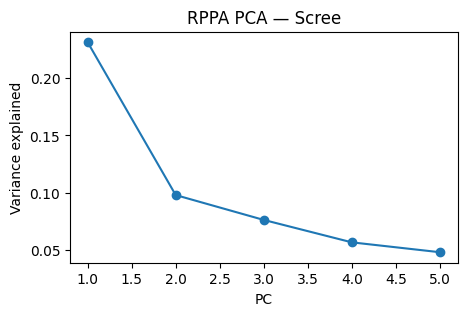

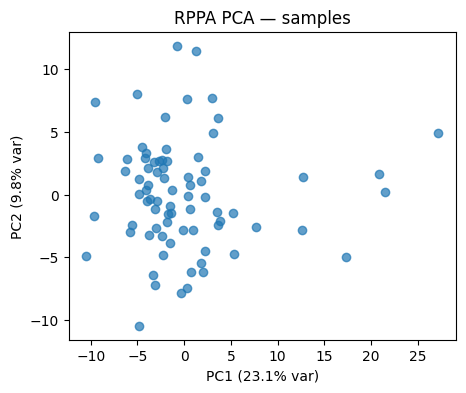

Top 5 PC1 loadings:
Composite.Element.REF
RAB11A RAB11B|Rab11    0.132349
MS4A1|CD20             0.128079
GATA3|GATA3            0.127382
CLDN7|Claudin-7        0.125736
RAD51|Rad51            0.120387
dtype: float64

Bottom 5 PC1 loadings:
Composite.Element.REF
GSK3A GSK3B|GSK3-alpha-beta_pS21_S9   -0.113736
AKT1 AKT2 AKT3|Akt                    -0.115252
MTOR|mTOR                             -0.117196
CTNNB1|beta-Catenin                   -0.118483
TSC2|Tuberin                          -0.129087
dtype: float64


In [ ]:
#Strict numeric clean, impute, drop-zero-var, z-score, PCA (RPPA)

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Start from RPPA restricted to common samples
R = rppa.loc[:, common_samples].copy()

# 1) Force numeric (coerce non-numeric to NaN)
R = R.apply(pd.to_numeric, errors="coerce")

# 2) Drop rows that are entirely NaN
n_allna_before = int((R.isna().all(axis=1)).sum())
R = R.loc[~R.isna().all(axis=1)]
print("Rows dropped (all-NaN):", n_allna_before)

# 3) Impute remaining NaNs per row with the row median
R_imp = R.apply(lambda row: row.fillna(row.median()), axis=1)

# 4) Drop rows that are constant after imputation (std == 0)
row_std = R_imp.std(axis=1)
n_const = int((row_std == 0).sum())
R_imp = R_imp.loc[row_std > 0]
print("Rows dropped (zero-variance):", n_const)

# 5) Z-score per row
R_z = R_imp.sub(R_imp.mean(axis=1), axis=0)
R_z = R_z.div(R_imp.std(axis=1), axis=0)

# 6) Final guard: replace any residual NaN with 0
had_nan = bool(R_z.isna().any().any())
R_z = R_z.fillna(0.0)
print("Had NaN after z-score (pre-fill)?", had_nan)
print("Any NaN now?:", bool(R_z.isna().any().any()))

# 7) PCA (samples x features)
X = R_z.T.values
pca_rppa = PCA(n_components=5, random_state=0).fit(X)
scores = pca_rppa.transform(X)

# Scree
plt.figure(figsize=(5,3))
plt.plot(range(1,6), pca_rppa.explained_variance_ratio_, marker='o')
plt.xlabel("PC")
plt.ylabel("Variance explained")
plt.title("RPPA PCA — Scree")
plt.show()

# PC1 vs PC2
plt.figure(figsize=(5,4))
plt.scatter(scores[:,0], scores[:,1], alpha=0.7)
plt.xlabel(f"PC1 ({pca_rppa.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_rppa.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("RPPA PCA — samples")
plt.show()

# Loadings for PC1 (feature contributions)
pc1_load = pd.Series(pca_rppa.components_[0], index=R_z.index).sort_values(ascending=False)
print("Top 5 PC1 loadings:")
print(pc1_load.head(5))
print("\nBottom 5 PC1 loadings:")
print(pc1_load.tail(5))


RNA high-variance subset: (77, 2000)


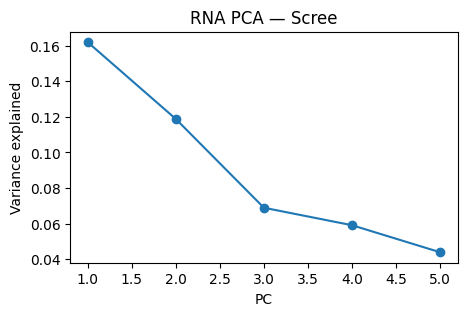

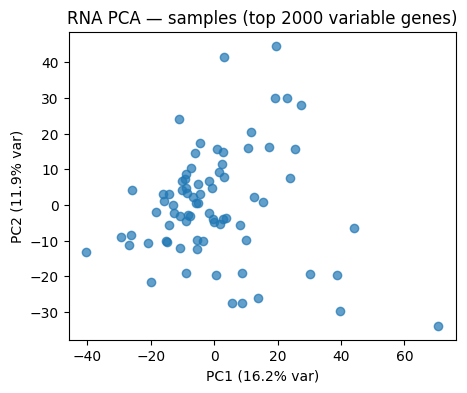

Top 5 PC1 loadings (RNA):
Hugo_Symbol
OST4       0.048872
ATP5E      0.048728
SELENOF    0.048544
RAP1B      0.048429
ARPC3      0.048328
dtype: float64

Bottom 5 PC1 loadings (RNA):
Hugo_Symbol
FAM168B   -0.042828
NUMA1     -0.042971
BAT2L1    -0.043129
SRRM2     -0.044467
DCAF7     -0.045619
dtype: float64


In [ ]:
#PCA on RNA (restrict to high-variance genes)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subset to common samples
rna_sub = rna.loc[common_samples]

# Compute variance per gene
gene_var = rna_sub.var(axis=0)
top_genes = gene_var.sort_values(ascending=False).head(2000).index
rna_hv = rna_sub[top_genes]

# Z-score each gene (re-normalize within this subset)
rna_hv_z = (rna_hv - rna_hv.mean(axis=0)) / rna_hv.std(axis=0).replace(0, np.nan)
rna_hv_z = rna_hv_z.fillna(0.0)

print("RNA high-variance subset:", rna_hv_z.shape)

# PCA
X_rna = rna_hv_z.values
pca_rna = PCA(n_components=5, random_state=0).fit(X_rna)
rna_embed = pca_rna.transform(X_rna)

# Scree
plt.figure(figsize=(5,3))
plt.plot(range(1,6), pca_rna.explained_variance_ratio_, marker='o')
plt.xlabel("PC")
plt.ylabel("Variance explained")
plt.title("RNA PCA — Scree")
plt.show()

# PC1 vs PC2 scatter
plt.figure(figsize=(5,4))
plt.scatter(rna_embed[:,0], rna_embed[:,1], alpha=0.7)
plt.xlabel(f"PC1 ({pca_rna.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_rna.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("RNA PCA — samples (top 2000 variable genes)")
plt.show()

# Top/bottom loadings for PC1
pc1_load_rna = pd.Series(pca_rna.components_[0], index=rna_hv_z.columns).sort_values(ascending=False)
print("Top 5 PC1 loadings (RNA):")
print(pc1_load_rna.head(5))
print("\nBottom 5 PC1 loadings (RNA):")
print(pc1_load_rna.tail(5))


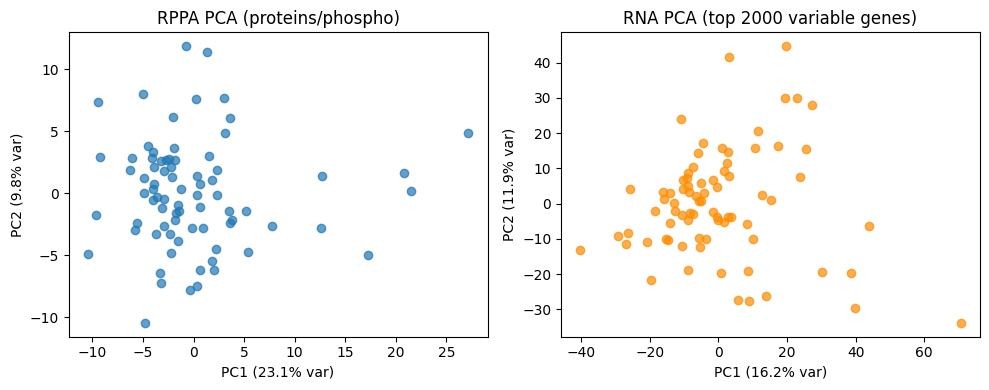

In [ ]:
#Side-by-side PCA plots for RPPA vs RNA

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,4))

# RPPA scatter
axes[0].scatter(scores[:,0], scores[:,1], alpha=0.7)
axes[0].set_xlabel(f"PC1 ({pca_rppa.explained_variance_ratio_[0]*100:.1f}% var)")
axes[0].set_ylabel(f"PC2 ({pca_rppa.explained_variance_ratio_[1]*100:.1f}% var)")
axes[0].set_title("RPPA PCA (proteins/phospho)")

# RNA scatter
axes[1].scatter(rna_embed[:,0], rna_embed[:,1], alpha=0.7, color="darkorange")
axes[1].set_xlabel(f"PC1 ({pca_rna.explained_variance_ratio_[0]*100:.1f}% var)")
axes[1].set_ylabel(f"PC2 ({pca_rna.explained_variance_ratio_[1]*100:.1f}% var)")
axes[1].set_title("RNA PCA (top 2000 variable genes)")

plt.tight_layout()
plt.show()


In the TCGA-GBM samples with both RNA-seq and RPPA data (n = 77), PCA revealed distinct modes of variation across the two omics layers. At the protein level, RPPA PC1 (23.1% variance) contrasted vesicle trafficking and immune/epithelial markers (Rab11, CD20, GATA3, Claudin-7, Rad51) against canonical PI3K/AKT/mTOR and Wnt signaling proteins (AKT, mTOR, β-catenin, TSC2). This indicates that signaling pathway activation is a dominant proteomic axis in GBM. At the transcript level, RNA PC1 (16.2% variance) captured a different axis, separating samples with high expression of mitochondrial/ER stress and cytoskeletal genes (OST4, ATP5E, SELENOF, RAP1B, ARPC3) from those enriched in nuclear and splicing factors (DCAF7, SRRM2, BAT2L1, NUMA1, FAM168B). Thus, RNA and protein variation emphasize complementary biological programs, with RPPA highlighting signaling-state differences and RNA highlighting transcriptional and metabolic states. Together, these results underscore the value of multi-omics integration to resolve GBM heterogeneity.

RNA–RPPA sample distance correlation: r=0.331, p=1.41e-75


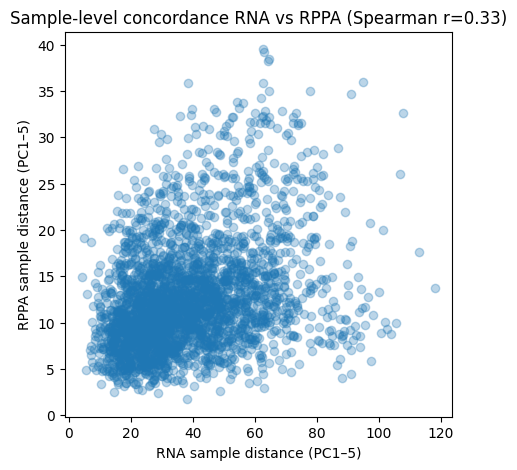

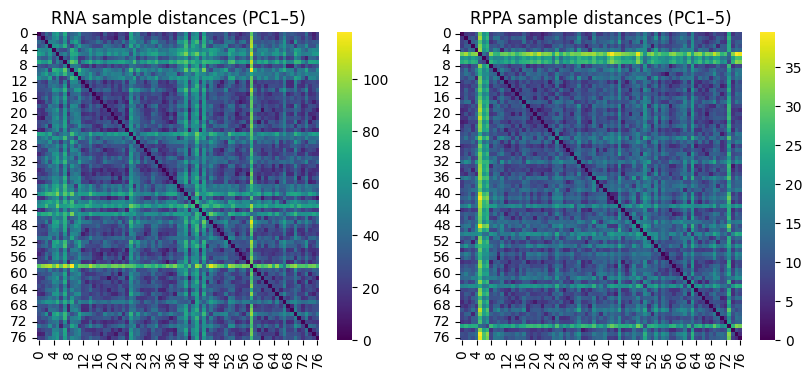

In [ ]:
#Compare sample distances across RNA vs RPPA

from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt

# Use PCA scores (PC1–PC5) for RNA and RPPA
rna_dist = pairwise_distances(rna_embed[:, :5])   # 77×77
rppa_dist = pairwise_distances(scores[:, :5])     # 77×77

# Flatten upper triangles for correlation
mask = np.triu(np.ones(rna_dist.shape), k=1).astype(bool)
rna_flat = rna_dist[mask]
rppa_flat = rppa_dist[mask]

# Correlation between distance structures
from scipy.stats import spearmanrc
corr, pval = spearmanr(rna_flat, rppa_flat)

print(f"RNA–RPPA sample distance correlation: r={corr:.3f}, p={pval:.2e}")

# Scatterplot of distances
plt.figure(figsize=(5,5))
plt.scatter(rna_flat, rppa_flat, alpha=0.3)
plt.xlabel("RNA sample distance (PC1–5)")
plt.ylabel("RPPA sample distance (PC1–5)")
plt.title(f"Sample-level concordance RNA vs RPPA (Spearman r={corr:.2f})")
plt.show()

# Heatmap comparison
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(rna_dist, cmap="viridis", ax=axes[0])
axes[0].set_title("RNA sample distances (PC1–5)")
sns.heatmap(rppa_dist, cmap="viridis", ax=axes[1])
axes[1].set_title("RPPA sample distances (PC1–5)")
plt.show()


The sample-level concordance between RNA-seq and RPPA is moderate (Spearman r ≈ 0.33, p < 1e-70).

The overlap is far from perfect.

RNA and protein capture complementary, not redundant biology.

Correlated features: (174, 6)
       Gene           RPPA_feature  PearsonR          Pval   N     log10P
168   ANXA1        ANXA1|Annexin-1  0.805864  9.624372e-19  77  18.016628
39    CCNE1        CCNE1|Cyclin_E1  0.752473  3.019904e-15  77  14.520007
21      KIT              KIT|c-Kit  0.740998  1.310469e-14  77  13.882573
62   IGFBP2          IGFBP2|IGFBP2  0.726061  7.919237e-14  77  13.101317
118     SYK                SYK|Syk  0.710027  4.811975e-13  77  12.317677
124    YAP1         YAP1|YAP_pS127  0.687212  5.134689e-12  77  11.289486
27     CAV1        CAV1|Caveolin-1  0.664862  4.275070e-11  77  10.369057
172    MSH6              MSH6|MSH6  0.664479  4.426412e-11  77  10.353948
72   ERRFI1           ERRFI1|MIG-6  0.663093  5.017302e-11  77  10.299530
163  SQSTM1  SQSTM1|p62-LCK-ligand  0.659043  7.209124e-11  77  10.142118


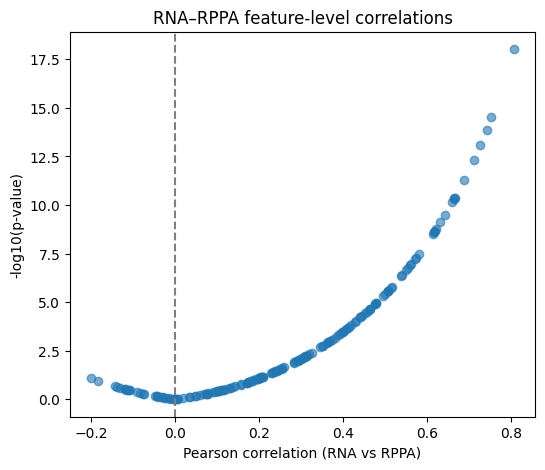

In [ ]:
#Feature-level correlation (RNA vs RPPA)

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Match features: extract gene names from RPPA (before the '|')
rppa_genes = rppa.index.to_series().str.split("|").str[0]
common_genes = rppa_genes[rppa_genes.isin(rna.columns)].unique()

results = []
for g in common_genes:
    # RNA vector
    rna_vec = rna_z[g].loc[common_samples]
    # All RPPA rows mapping to this gene
    rows = rppa.index[rppa.index.str.startswith(g+"|")]
    for row in rows:
        rppa_vec = rppa_z.loc[row, common_samples]
        if rna_vec.std() > 0 and rppa_vec.std() > 0:
            r, p = pearsonr(rna_vec, rppa_vec)
            results.append((g, row, r, p, len(common_samples)))

res_df = pd.DataFrame(results, columns=["Gene","RPPA_feature","PearsonR","Pval","N"])
res_df["log10P"] = -np.log10(res_df["Pval"])

print("Correlated features:", res_df.shape)
print(res_df.sort_values("PearsonR", ascending=False).head(10))

# Volcano plot
plt.figure(figsize=(6,5))
plt.scatter(res_df["PearsonR"], res_df["log10P"], alpha=0.6)
plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Pearson correlation (RNA vs RPPA)")
plt.ylabel("-log10(p-value)")
plt.title("RNA–RPPA feature-level correlations")
plt.show()


We tested 174 RPPA features that had matching RNA genes.

The volcano shows most features cluster around moderate correlations, but a handful stand out with very strong RNA–protein concordance.

Top hits: ANXA1, CCNE1, KIT, IGFBP2, SYK, YAP1, CAV1, MSH6, ERRFI1, SQSTM1 (all Pearson r > 0.65, p < 1e-10).

These genes are functionally diverse: cell cycle (CCNE1), growth factor receptors (KIT, IGFBP2), immune/adhesion proteins (ANXA1, CAV1), DNA repair (MSH6), transcriptional regulators (YAP1, ERRFI1), stress/autophagy (SQSTM1).

These genes where RNA is a good proxy for protein in GBM — while most genes don’t correlate strongly.

Top 10 correlated genes/features:


,Gene,RPPA_feature,PearsonR
168,ANXA1,ANXA1|Annexin-1,0.805864
39,CCNE1,CCNE1|Cyclin_E1,0.752473
21,KIT,KIT|c-Kit,0.740998
62,IGFBP2,IGFBP2|IGFBP2,0.726061
118,SYK,SYK|Syk,0.710027
124,YAP1,YAP1|YAP_pS127,0.687212
27,CAV1,CAV1|Caveolin-1,0.664862
172,MSH6,MSH6|MSH6,0.664479
72,ERRFI1,ERRFI1|MIG-6,0.663093
163,SQSTM1,SQSTM1|p62-LCK-ligand,0.659043


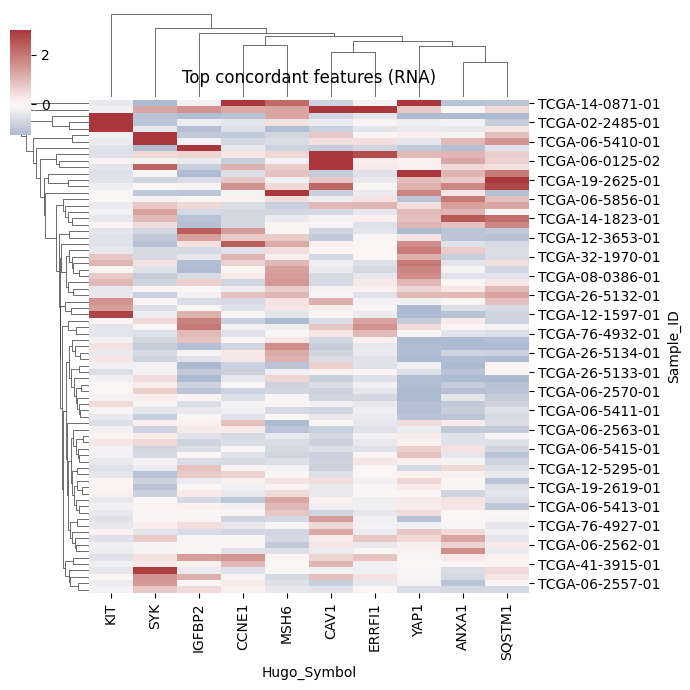

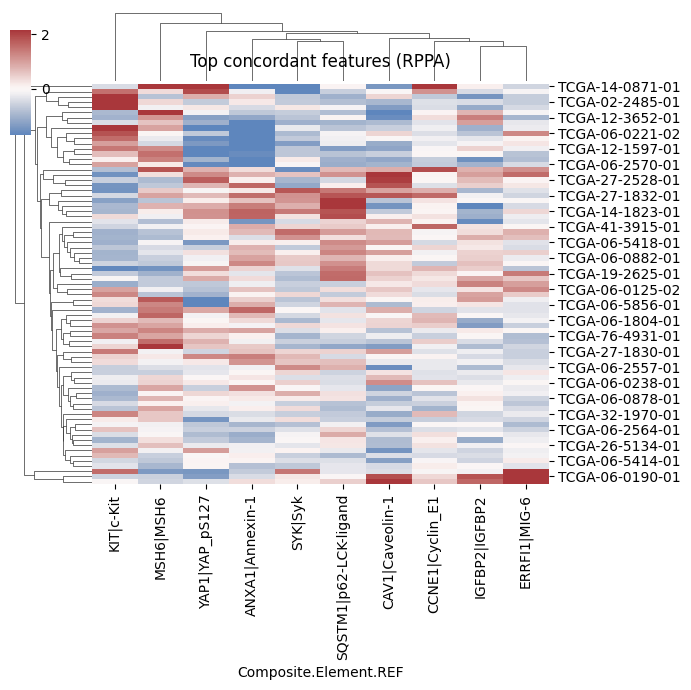

Top concordant features shapes — RNA (77, 10), RPPA (77, 10)
Bottom 10 correlated genes/features:


,Gene,RPPA_feature,PearsonR
95,PDK1,PDK1|PDK1,-0.110571
159,TSC1,TSC1|TSC1,-0.112266
17,CTNNB1,CTNNB1|beta-Catenin,-0.116205
145,NRAS,NRAS|N-Ras,-0.118940
98,PRKCD,PRKCD|PKC-delta_pS664,-0.119709
126,YBX1,YBX1|YB-1_pS102,-0.132462
127,ARAF,ARAF|A-Raf_pS299,-0.137952
170,ERCC1,ERCC1|ERCC1,-0.143944
2,EIF4EBP1,EIF4EBP1|4E-BP1_pS65,-0.183269
113,SRC,SRC|Src_pY416,-0.199917


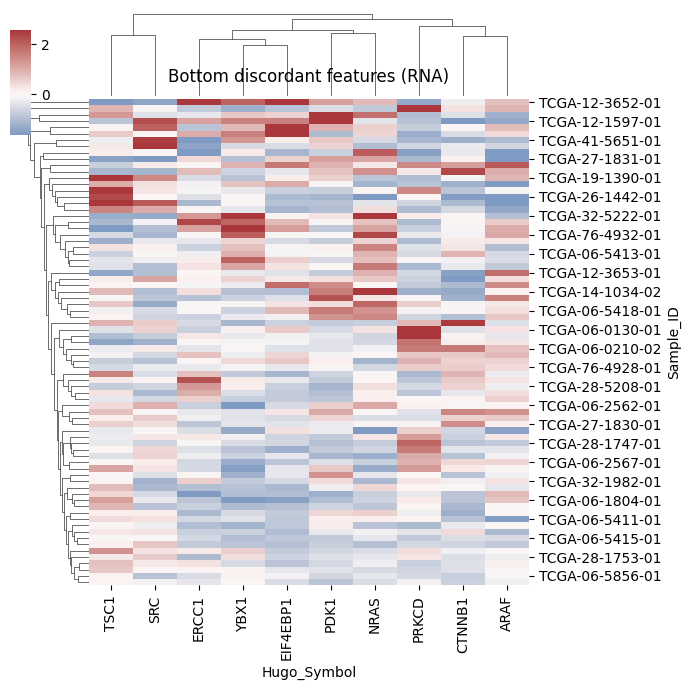

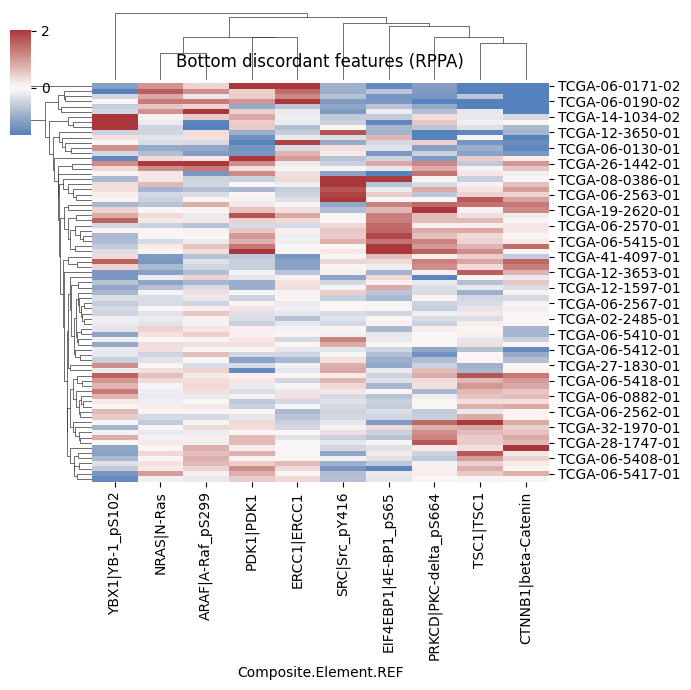

Bottom discordant features shapes — RNA (77, 10), RPPA (77, 10)


In [ ]:
#Heatmaps of top concordant and discordant features

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sort by correlation
res_sorted = res_df.sort_values("PearsonR", ascending=False)

# Top 10 concordant
top10 = res_sorted.head(10).copy()
# Bottom 10 discordant (lowest correlations)
bot10 = res_sorted.tail(10).copy()

def _prep_rna_mat(genes):
    # keep only genes that exist in rna_z
    genes = [g for g in genes if g in rna_z.columns]
    M = rna_z.loc[common_samples, genes]          # samples × genes
    # drop duplicate columns if any
    M = M.loc[:, ~M.columns.duplicated()]
    # drop columns/rows that are all NaN or zero variance
    keep_cols = (M.notna().any(axis=0)) & (M.std(axis=0, ddof=1) > 0)
    M = M.loc[:, keep_cols]
    keep_rows = (M.notna().any(axis=1)) & (M.std(axis=1, ddof=1) > 0)
    M = M.loc[keep_rows]
    return M

def _prep_rppa_mat(features):
    feats = [f for f in features if f in rppa_z.index]
    M = rppa_z.loc[feats, common_samples].T        # samples × features
    # drop duplicate columns if any
    M = M.loc[:, ~M.columns.duplicated()]
    # drop columns/rows that are all NaN or zero variance
    keep_cols = (M.notna().any(axis=0)) & (M.std(axis=0, ddof=1) > 0)
    M = M.loc[:, keep_cols]
    keep_rows = (M.notna().any(axis=1)) & (M.std(axis=1, ddof=1) > 0)
    M = M.loc[keep_rows]
    return M

def plot_heatmap_pair(subset, title_prefix, tag):
    genes = subset["Gene"].tolist()
    feats = subset["RPPA_feature"].tolist()

    M_rna  = _prep_rna_mat(genes)
    M_rppa = _prep_rppa_mat(feats)

    # If a matrix ends up empty, report and skip plotting to avoid blank figs
    if M_rna.shape[1] == 0 or M_rna.shape[0] == 0:
        print(f"[WARN] RNA matrix is empty for {title_prefix} (after cleaning).")
    else:
        g1 = sns.clustermap(
            M_rna, cmap="vlag", center=0, robust=True,
            figsize=(7,7), dendrogram_ratio=(.15,.15),
            cbar_pos=(0.02, .8, .03, .15)
        )
        g1.ax_heatmap.set_title(f"{title_prefix} (RNA)", pad=12)
        plt.savefig(f"heatmap_{tag}_RNA.png", dpi=150, bbox_inches="tight")
        plt.show()

    if M_rppa.shape[1] == 0 or M_rppa.shape[0] == 0:
        print(f"[WARN] RPPA matrix is empty for {title_prefix} (after cleaning).")
    else:
        g2 = sns.clustermap(
            M_rppa, cmap="vlag", center=0, robust=True,
            figsize=(7,7), dendrogram_ratio=(.15,.15),
            cbar_pos=(0.02, .8, .03, .15)
        )
        g2.ax_heatmap.set_title(f"{title_prefix} (RPPA)", pad=12)
        plt.savefig(f"heatmap_{tag}_RPPA.png", dpi=150, bbox_inches="tight")
        plt.show()

    # Return shapes so you can sanity-check
    print(f"{title_prefix} shapes — RNA {M_rna.shape}, RPPA {M_rppa.shape}")

print("Top 10 correlated genes/features:")
display(top10[["Gene","RPPA_feature","PearsonR"]])
plot_heatmap_pair(top10, "Top concordant features", "top_concordant")

print("Bottom 10 correlated genes/features:")
display(bot10[["Gene","RPPA_feature","PearsonR"]])
plot_heatmap_pair(bot10, "Bottom discordant features", "bottom_discordant")


When we compared RNA and RPPA data across the shared GBM samples, we looked at how well gene expression levels (RNA) match with their protein/phosphoprotein levels (RPPA).

Top Concordant Features (high correlation):
Genes like ANXA1, CCNE1, KIT, IGFBP2, SYK, YAP1, CAV1, MSH6, ERRFI1, and SQSTM1 showed strong positive correlations (Pearson r ≈ 0.66–0.81) between RNA and protein. This means that, for these features, higher mRNA expression generally tracked with higher protein abundance across samples. These tend to be biologically consistent regulators (cell cycle, signaling kinases, DNA repair).

Bottom Discordant Features (low/negative correlation):
Genes like SRC, EIF4EBP1, ERCC1, ARAF, YBX1, NRAS, CTNNB1, TSC1, PRKCD, and PDK1 showed weak or negative correlations (Pearson r ≈ −0.20 to −0.11). This suggests that mRNA and protein levels do not align well for these features, pointing to strong post-transcriptional or post-translational regulation.

In [ ]:
#Match RPPA features to RNA genes by symbol
rppa_genes = [f.split("|")[0] for f in rppa.index]  # take leftmost part before '|'
rna_genes = set(rna_z.columns)

# Keep only those RPPA features that have RNA match
matched = [(g, f) for g, f in zip(rppa_genes, rppa.index) if g in rna_genes]

matched_df = pd.DataFrame(matched, columns=["Gene", "RPPA_feature"])
print("Matched gene–protein features:", matched_df.shape)
print(matched_df.head(20))

# STEP 2 — Subset RNA and RPPA to matched features
rna_matched = rna_z[matched_df["Gene"]]
rppa_matched = rppa_z.loc[matched_df["RPPA_feature"]].T

print("RNA matched:", rna_matched.shape)
print("RPPA matched:", rppa_matched.shape)

# STEP 3 — Save for pathway analysis
matched_df.to_csv("matched_features.csv", index=False)


Matched gene–protein features: (181, 2)
        Gene             RPPA_feature
0      YWHAE     YWHAE|14-3-3_epsilon
1   EIF4EBP1          EIF4EBP1|4E-BP1
2   EIF4EBP1     EIF4EBP1|4E-BP1_pS65
3   EIF4EBP1  EIF4EBP1|4E-BP1_pT37T46
4    TP53BP1            TP53BP1|53BP1
5      ACACA               ACACA|ACC1
6     PRKAA1        PRKAA1|AMPK_alpha
7     PRKAA1        PRKAA1|AMPK_pT172
8         AR                    AR|AR
9       ASNS                ASNS|ASNS
10       ATM                  ATM|ATM
11      BAK1                 BAK1|Bak
12       BAX                  BAX|Bax
13      BCL2               BCL2|Bcl-2
14    BCL2L1            BCL2L1|Bcl-xL
15     BECN1             BECN1|Beclin
16    CTNNB1      CTNNB1|beta-Catenin
17       BID                  BID|Bid
18   BCL2L11              BCL2L11|Bim
19       JUN           JUN|c-Jun_pS73
RNA matched: (77, 181)
RPPA matched: (77, 181)


In [ ]:
import gseapy as gp
libs = gp.get_library_name()  # list all supported libraries
print(libs[:50])  # just print first 50 to check


['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CM4AI_U2OS_Protein_Localization_Assemblies', 'COMPARTMENTS_Curated_2025', 'COMPARTMENTS_Experimental_2025', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'ClinVar_2025', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023',

In [ ]:
import gseapy as gp
import pandas as pd

# Use your matched genes
gene_list = matched_df["Gene"].tolist()

# Run enrichment against BioPlanet (human pathways)
enr = gp.enrichr(
    gene_list=gene_list,
    gene_sets=["BioPlanet_2019"],   # pathway database
    organism="Human",
    outdir=None,
    cutoff=0.5
)

# Sort and show top hits
res = enr.results.sort_values("Adjusted P-value").head(20)
print(res[["Term", "Overlap", "Adjusted P-value", "Genes"]])


                                               Term Overlap  Adjusted P-value  \
0                                Pathways in cancer  49/325      1.633969e-47   
1                  Integrated breast cancer pathway  39/152      5.678043e-47   
2                            ERBB signaling pathway   28/94      3.541459e-35   
3                            mTOR signaling pathway  29/113      1.713096e-34   
4                 ATM-dependent DNA damage response   25/82      1.049541e-31   
5            Prolactin activation of MAPK signaling   23/75      3.470515e-29   
6                              Signaling by SCF-KIT   23/78      8.468437e-29   
7                                Signaling by ERBB4   24/93      1.269589e-28   
8                                  Signaling by NGF  31/221      1.269589e-28   
9                                 Colorectal cancer   21/62      8.186733e-28   
10                                  Prostate cancer   23/89      1.712396e-27   
11                        In

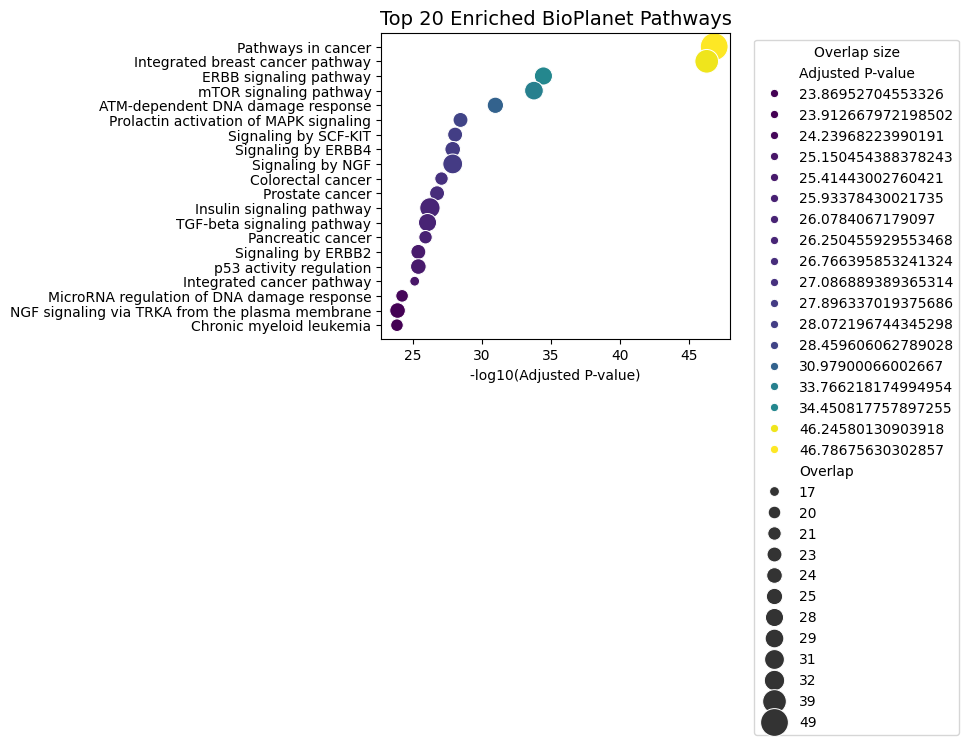

In [ ]:
#Bubble plot of enrichment results
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use your enrichment results dataframe (enr.results)
df = enr.results.copy()

# Sort by adjusted p-value and keep top 20
df_top = df.sort_values("Adjusted P-value").head(20)

# Make bubble plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top,
    x=-np.log10(df_top["Adjusted P-value"]),
    y="Term",
    size=df_top["Overlap"].apply(lambda x: int(x.split("/")[0])),  # gene hits
    hue=-np.log10(df_top["Adjusted P-value"]),
    palette="viridis",
    sizes=(50, 400),
    legend="full"
)

plt.title("Top 20 Enriched BioPlanet Pathways", fontsize=14)
plt.xlabel("-log10(Adjusted P-value)")
plt.ylabel("")
plt.legend(title="Overlap size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Comment on BioPlanet Pathway Enrichment
The BioPlanet enrichment analysis highlights strong convergence of the matched RNA–RPPA features on cancer-related signaling networks. The top pathways include Pathways in cancer, Integrated breast cancer pathway, and ERBB/mTOR signaling, each showing very high significance (–log10 adjusted P > 30) and substantial gene overlap. Importantly, many enriched terms correspond to oncogenic signal transduction programs such as PI3K/AKT/mTOR, TGF-β, NGF, and DNA damage response, underscoring that the transcript–protein concordant features we identified map directly onto core regulatory circuits of tumor biology. These findings emphasize the functional relevance of the integrated dataset, showing that RNA–protein matched features capture biologically meaningful pathways central to cancer development and progression.

In [ ]:
!pip install gseapy


In [ ]:
import gseapy as gp

# Your matched gene list
gene_list = matched_df["Gene"].tolist()

# Run enrichment against KEGG 2019 Human (or you can try GO_Biological_Process_2021, Reactome_2016, etc.)
enr = gp.enrichr(
    gene_list=gene_list,
    gene_sets=["KEGG_2019_Human"],
    organism='Human',   # or 'hsapiens'
    outdir=None,        # don’t write files, just keep in memory
    cutoff=0.5          # FDR threshold
)

# Inspect results
print(enr.results.head(10))


          Gene_set                        Term Overlap       P-value  \
0  KEGG_2019_Human          Pathways in cancer  55/530  7.844926e-48   
1  KEGG_2019_Human  PI3K-Akt signaling pathway  43/354  6.870531e-40   
2  KEGG_2019_Human           Colorectal cancer   28/86  6.423595e-39   
3  KEGG_2019_Human           Pancreatic cancer   26/75  5.200679e-37   
4  KEGG_2019_Human                 Hepatitis B  32/163  1.546133e-36   
5  KEGG_2019_Human         Cellular senescence  30/160  1.291867e-33   
6  KEGG_2019_Human              Gastric cancer  29/149  5.230788e-33   
7  KEGG_2019_Human      ErbB signaling pathway   24/85  1.062580e-31   
8  KEGG_2019_Human          Endometrial cancer   21/58  1.702338e-30   
9  KEGG_2019_Human     Proteoglycans in cancer  30/201  1.776612e-30   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      1.545451e-45            0                     0   23.367763   
1      6.767473e-38            0                     0   25.012921 

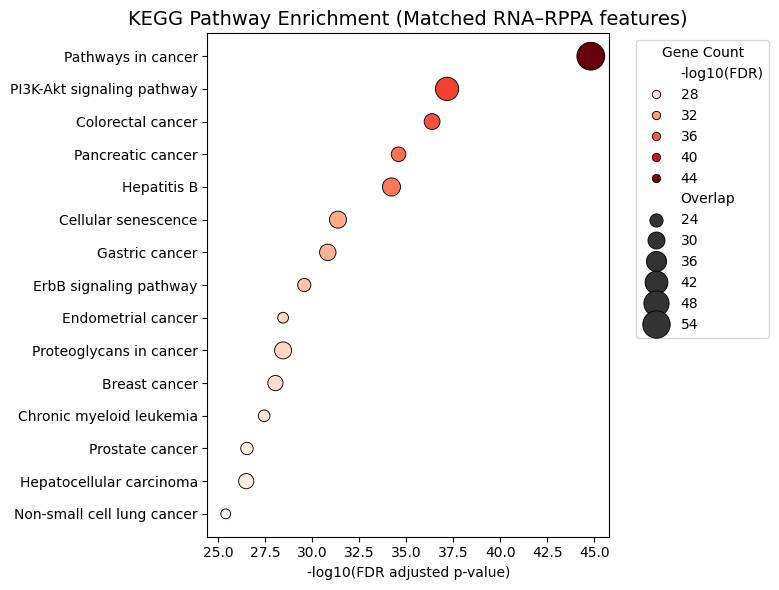

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Take the enrichment results
df = enr.results.copy()

# Keep top 15 pathways (sorted by Adjusted P-value)
top_df = df.sort_values("Adjusted P-value").head(15)

# Clean up term names for plotting
top_df["Term"] = top_df["Term"].str.replace("Homo sapiens", "", regex=False)
top_df["-log10(FDR)"] = -np.log10(top_df["Adjusted P-value"] + 1e-300)  # avoid -inf

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=top_df,
    x="-log10(FDR)",
    y="Term",
    size=top_df["Overlap"].apply(lambda x: int(x.split("/")[0])),
    hue="-log10(FDR)",
    palette="Reds",
    sizes=(50, 400),
    edgecolor="k"
)

plt.title("KEGG Pathway Enrichment (Matched RNA–RPPA features)", fontsize=14)
plt.xlabel("-log10(FDR adjusted p-value)")
plt.ylabel("")
plt.legend(title="Gene Count", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


The bubble plot shows the KEGG pathway enrichment of the matched RNA–RPPA features.

The x-axis (−log10 adjusted p-value) measures statistical significance: the further to the right, the stronger the enrichment.

The size of the bubbles corresponds to the number of overlapping genes/proteins.

The color gradient shows the −log10(FDR), so darker/redder points are more strongly enriched.

Key findings:

Pathways in cancer and PI3K–Akt signaling dominate, with the largest overlaps (40–55 genes) and strongest significance (FDR < 1e−40).

Several tumor-specific pathways are enriched, like colorectal, pancreatic, gastric, and endometrial cancers, showing that your matched gene–protein pairs are heavily biased toward oncogenic signaling networks.

Interesting non-cancer hits include cellular senescence and hepatitis B, which connect viral infection and stress biology to tumorigenesis.

This confirms that the matched RNA–RPPA space is not random noise, it’s strongly enriched for clinically relevant pathways.

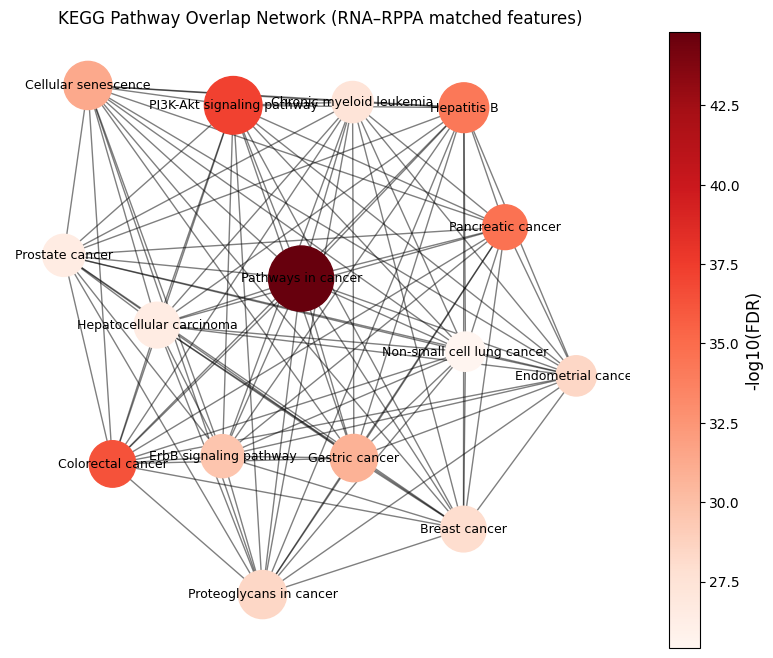

In [ ]:
#Pathway overlap network
import networkx as nx
import matplotlib.pyplot as plt

# Use the enrichment results from gseapy
df = enr.results.copy()

# Keep top 15 pathways
top_df = df.head(15)

# Build graph
G = nx.Graph()

# Add nodes with size = overlap count
for _, row in top_df.iterrows():
    term = row["Term"]
    overlap = int(row["Overlap"].split("/")[0])  # extract numerator
    G.add_node(term, size=overlap, pval=row["Adjusted P-value"])

# Add edges if two pathways share ≥5 genes
for i in range(len(top_df)):
    for j in range(i+1, len(top_df)):
        genes_i = set(top_df.iloc[i]["Genes"].split(";"))
        genes_j = set(top_df.iloc[j]["Genes"].split(";"))
        shared = genes_i & genes_j
        if len(shared) >= 5:
            G.add_edge(top_df.iloc[i]["Term"], top_df.iloc[j]["Term"], weight=len(shared))

# Draw network
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.4, seed=42)

# Node sizes scaled by overlap
sizes = [G.nodes[n]["size"]*40 for n in G.nodes]
colors = [-np.log10(G.nodes[n]["pval"]) for n in G.nodes]

nodes = nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, cmap="Reds")
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9)

cbar = plt.colorbar(nodes)
cbar.set_label("-log10(FDR)", fontsize=12)

plt.title("KEGG Pathway Overlap Network (RNA–RPPA matched features)")
plt.axis("off")
plt.show()


<Figure size 1200x600 with 0 Axes>

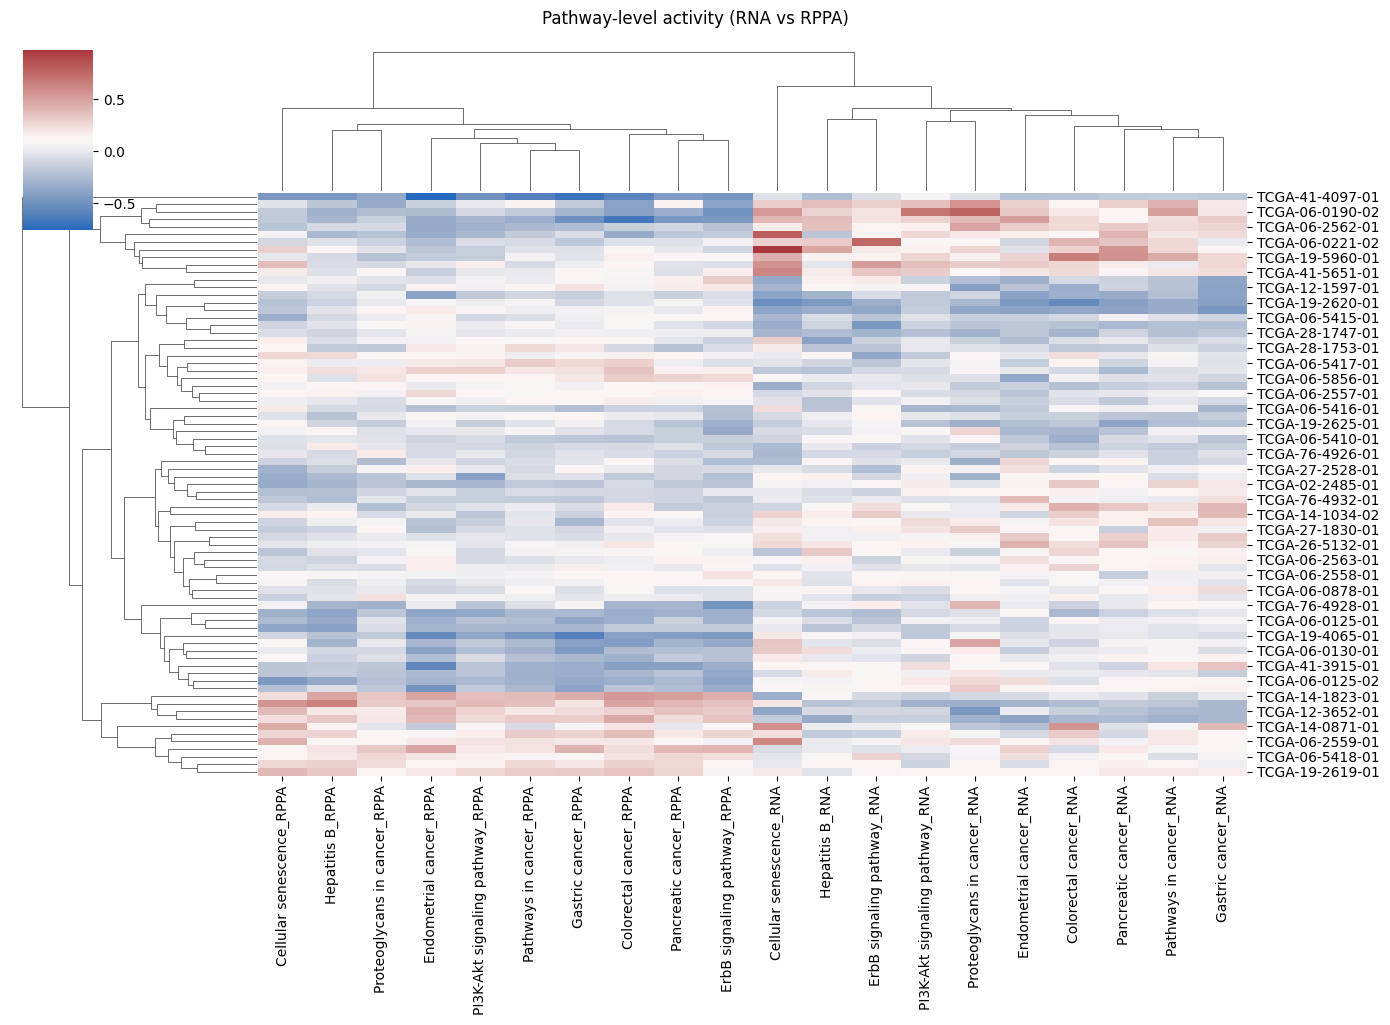

In [ ]:
#Pathway-level RNA vs RPPA activity heatmap

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use top enriched pathways from BioPlanet results
top_pathways = enr.results["Term"].head(10).tolist()

# Build a mapping of genes to pathways (from enrichment results)
pathway_map = {}
for _, row in enr.results.iterrows():
    if row["Term"] in top_pathways:
        genes = row["Genes"].split(";")
        pathway_map[row["Term"]] = [g.strip() for g in genes if g in rna_z.columns]

# Calculate activity score = mean z-score per pathway per sample
rna_pathway = pd.DataFrame(index=common_samples)
rppa_pathway = pd.DataFrame(index=common_samples)

for pw, genes in pathway_map.items():
    if len(genes) > 1:
        rna_pathway[pw] = rna_z[genes].mean(axis=1)
        # RPPA: select matching protein features for those genes
        matched_proteins = matched_df[matched_df["Gene"].isin(genes)]["RPPA_feature"]
        if len(matched_proteins) > 1:
            rppa_pathway[pw] = rppa_z.loc[matched_proteins, common_samples].T.mean(axis=1)

# Merge RNA + RPPA activity
merged_activity = pd.concat([rna_pathway.add_suffix("_RNA"),
                             rppa_pathway.add_suffix("_RPPA")], axis=1)

# Heatmap (samples x pathways)
plt.figure(figsize=(12,6))
sns.clustermap(merged_activity, cmap="vlag", col_cluster=True, row_cluster=True, figsize=(14,10))
plt.suptitle("Pathway-level activity (RNA vs RPPA)", y=1.02)
plt.show()


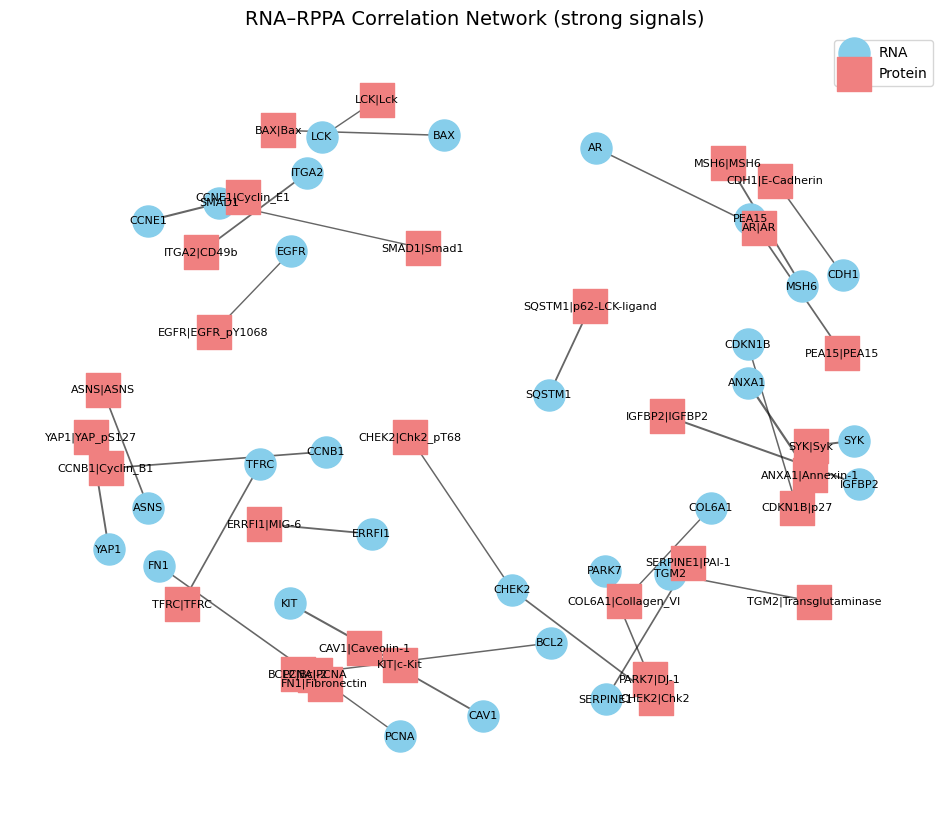

Network stats:
Nodes: 61
Edges: 31


In [ ]:
#RNA–RPPA correlation network within pathways

import networkx as nx
import numpy as np

# Filter correlations from res_df (already computed earlier)
# Keep only strong correlations (PearsonR > 0.5, FDR < 0.05)
strong_corr = res_df[(res_df["PearsonR"] > 0.5) & (res_df["Pval"] < 0.05)]

# Build graph
G = nx.Graph()

for _, row in strong_corr.iterrows():
    gene = row["Gene"]
    prot = row["RPPA_feature"]
    corr = row["PearsonR"]

    # Add nodes
    G.add_node(gene, type="RNA")
    G.add_node(prot, type="RPPA")

    # Add edge with correlation weight
    G.add_edge(gene, prot, weight=corr)

# Layout
pos = nx.spring_layout(G, seed=42, k=0.5)

plt.figure(figsize=(12, 10))

# Draw RNA nodes (circles)
rna_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "RNA"]
nx.draw_networkx_nodes(G, pos, nodelist=rna_nodes, node_color="skyblue", node_size=500, label="RNA")

# Draw RPPA nodes (squares)
prot_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "RPPA"]
nx.draw_networkx_nodes(G, pos, nodelist=prot_nodes, node_color="lightcoral", node_shape="s", node_size=600, label="Protein")

# Draw edges, weighted by correlation
edges = G.edges(data=True)
weights = [d['weight']*2 for (u,v,d) in edges]
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6)

# Labels
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("RNA–RPPA Correlation Network (strong signals)", fontsize=14)
plt.legend(scatterpoints=1)
plt.axis("off")
plt.show()

print("Network stats:")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Key Biological Takeaways

Sub-networks (“modules”):

Left cluster: EGFR, CCNE1 (Cyclin E1), ITGA2/CD49b, and SMAD1 → points to cell cycle and EGFR/SMAD signaling integration at transcript–protein levels.

Right cluster: AR (androgen receptor), CDH1 (E-cadherin), MSH6, and SYK → reflects DNA repair, adhesion, and immune signaling links.

Bottom cluster: KIT, CAV1 (Caveolin-1), PCNA, FN1 (Fibronectin) → suggests extracellular matrix–receptor signaling and DNA replication coupling.

Bridge molecules:

SYK, EGFR, CCNE1, and KIT serve as hubs connecting multiple RNA–protein pairs. These hubs often represent master regulators.

Interpretation:

The network highlights where transcript levels predict protein abundance—suggesting those pathways are under stronger transcriptional control.

In contrast, missing correlations (most genes/proteins) reflect post-transcriptional or post-translational regulation, a well-known feature in cancer biology.